# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек

Перед тем, как начинать работать с данными импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Загрузка данных

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
print(geo_data_0.info())
print()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
print(geo_data_1.info())
print()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
print(geo_data_2.info())
print()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Все данные выгрузились корректно!

### Предобработка

Т.к. в наших данных присутствуют только количественные признаки, явные и неявные дубликаты нам выявлять не нужно. На первичном осмотре данных пропущенных значений не обнаружилось, поэтому приступим к характеру распределения наших признаков на исследовательском анализе данных

### EDA

In [5]:
def eda(data):
    #строковые столбцы
    object_columns = data.select_dtypes(include='object').columns
    
    #числовые столбцы
    numeric_columns = data.select_dtypes(include='number').columns
    
    #гистограммы и ящики с усами для числовых столбцов
    for column in numeric_columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        
        sns.histplot(data[column], kde=False, bins=20, color='blue', alpha=0.5, ax=axes[0])
        axes[0].set_title(f'Гистограмма столбца\n{column}')
        axes[0].set_ylabel('Частота')
        axes[0].set_xlabel(f'{column}')
        axes[0].axvline(data[column].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
        axes[0].axvline(data[column].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
        axes[0].legend()

        sns.boxplot(x=data[column], ax=axes[1], color='skyblue')
        axes[1].set_title(f'Ящик с усами для\n{column}')
        axes[1].set_xlabel(f'{column}')

        plt.tight_layout()
        plt.show()

        print(data[column].describe())

#### Первый регион

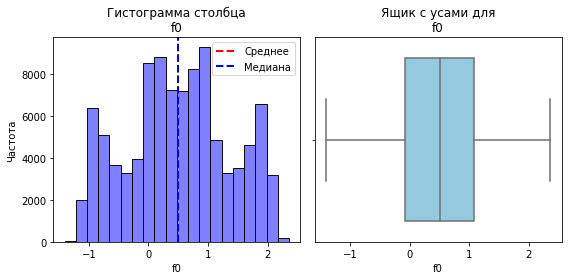

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64


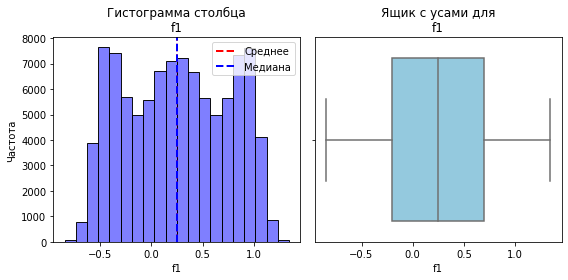

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64


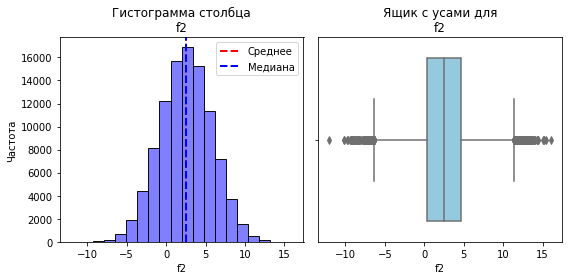

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64


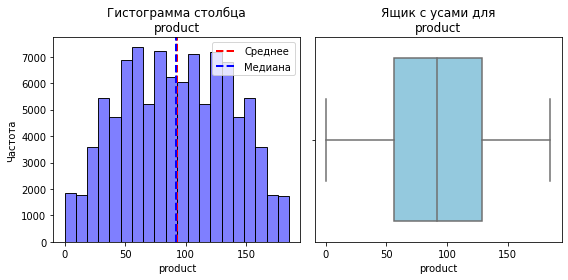

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


In [6]:
eda(geo_data_0.drop('id', 1))

Изучим каждый признак в датасете с данными о первом регионе:
___
`f0`:
- Распределение больше напоминает мультимодальное с тремя ярковыраженными пиками.
- Ящик с усами наличие выбросов в данных не показал.
- Среднее значение по выборке составило 0.5. Медиана такая же, 0.5. Смещения и удлиненных хвостов не обнаружено, Эти статистики совпадают
- Данные собраны в проммежутке от мин. значения -1.4 до макс. 2.36
___
`f1`:
- Распределение похоже на мультимодальное, но не такое выраженное, как у первого признака. Все так данные собраны у среднего 0.25.
- Ящик с усами наличие выбросов в данных не показал.
- Медиана и Среднее воспадают
- Мин. знач. -0.85, а макс. знач. 1.34
- Гистограмма зеркалит по линии среднего. Это может указывать на то, что этот столбец хранит в себе значения результатов измерений. Для данного типа данных характерно такое распределение. 
___
`f2`:
- Гистограмма сужается к центру. Скорее всего признак имеет низкую дисперсию
- Тем не менее ящик с усами показывает выбросы по обоим хвостам
- Среднее и медиана опять совпали. 2.5
- Мин и макс значения равны -12 и 16 соответственно
___
`product` - целевой:
- Данные об объемах запасов нефти имеют нормальное распределение со средним и медианой 92 ед. 
- Выбросы отсутствуют
- Мин и макс равны 0 и 185 ед. соответственно.
____

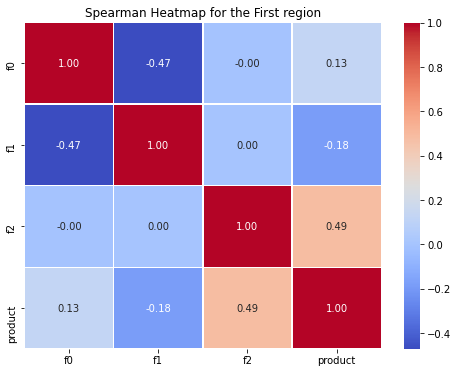

In [7]:
spearman_matrix = geo_data_0.drop('id', 1).corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman Heatmap for the First region")
plt.show()

Корреляционный анализ показал, что `f2` имеет среднюю положительную корреляцию с целевой переменной `product`. Также мы видим, что у признаков `f0` и `f1` наблюдается умеренная отрицательная корреляция. В любом случае, мы выяснили, что линейная зависимость в данных присутствует, поэтому Линейная регрессия нам подходит

#### Второй регион

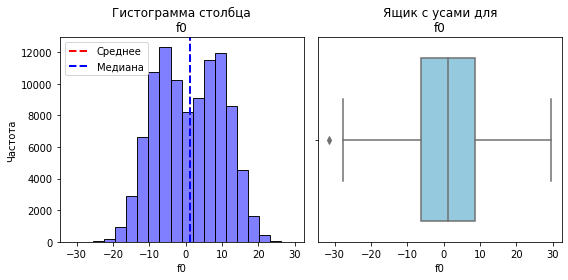

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64


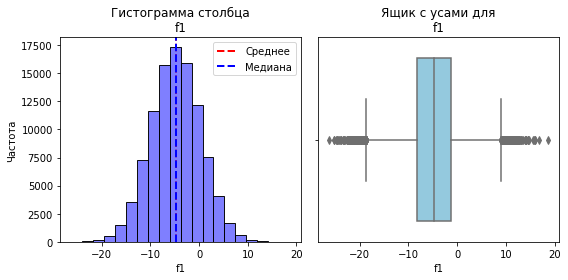

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64


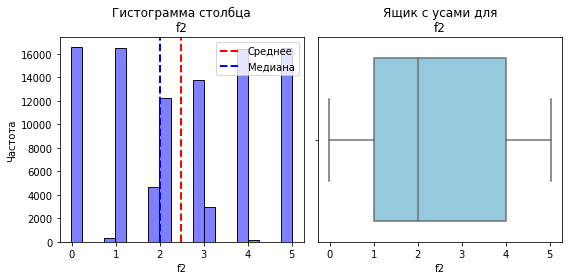

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64


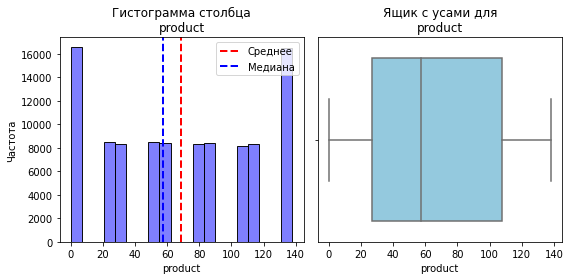

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


In [8]:
eda(geo_data_1.drop('id', 1))

___
`f0`:
- Гистограмма имеет бимодальное распределение с выбросами у левого хвоста.
- Среднее и медиана равны 1.14 и 1.15 соответственно. Учитывая разброс и высокое стандартное отклонение на графики эти прямые совпали.
- Мин и макс значения равны -32 и 29 соответственно
___
`f1`:
- Судя по гистограмме данные распределены нормально и имеют низкую дисперсию
- По обе стороны усов на ящике замечены выбросы
- Минимальное и максимальное значения равны -26 и 18 соответственно
___
`f2`:
- Среднее и медиана равны 2.5 и 2 соответственно. Гистограмма смещена вправо, это может указывать на небольшое преобладание высоких значений в данных.
- Тем не менее распределение данных равномерное, в диапазоне [0, 1] и [4, 5] значения равновероятны. На гистограмме видно, что данные сгруппированы. На это все указывает прямоугольная форма гистограммы
- Мин и макс значения равны -0.02 и 5 соответственно. 
___
`product` - целевой:
- Гистограмма зеркальная относительно оси среднего значения. Также заметна группировка данных. На диапазонах [20, 30], [50, 60], [80, 90] и [110, 120] значения равновероятны. 
- При этом заметны пики у минимального и максимального значений 0 и 138 соответственно.
- Судя по среднему и медиане (69 и 57 соответственно) имеется скошенность вправо, что также может свидетельствовать о небольшом преобладании высоких значений. Об этом говорит пик у максимума. 
____

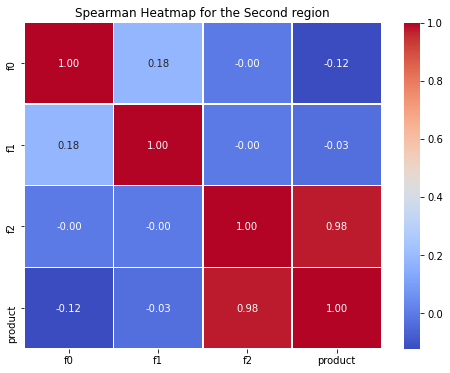

In [9]:
spearman_matrix = geo_data_1.drop('id', 1).corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman Heatmap for the Second region")
plt.show()

Наблюдается сильная прямопропорциональная корреляция между признаком `f2` и целевым `product`. Линейная зависимость присутствует

#### Третий регион

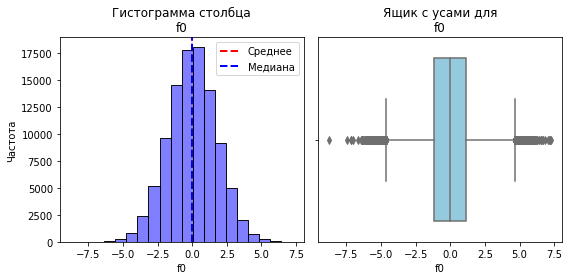

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64


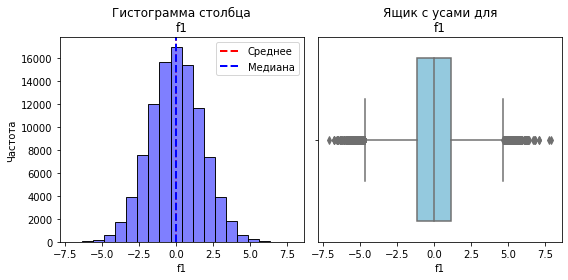

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64


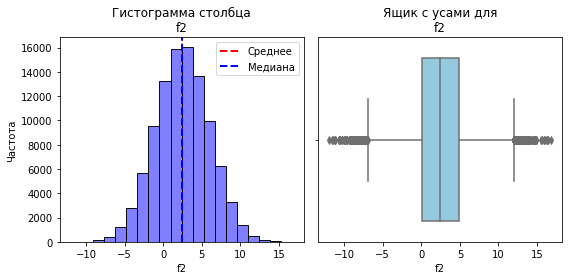

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64


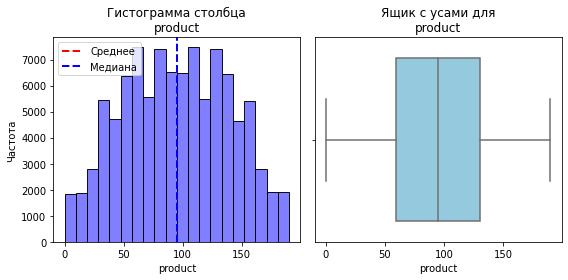

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


In [10]:
eda(geo_data_2.drop('id', 1))

___
`f0`:
- Распределение нормальное. Дисперсия низкая
- Ящик с усами показывает наличие выбросов в данных.
- Среднее значение по выборке составило 0. Медиана такая же, 0. Смещения и удлиненных хвостов не обнаружено, Эти статистики совпадают
- Данные собраны в проммежутке от мин. значения -8.8 до макс. 7.2
___
`f1`:
- - Распределение нормальное. Дисперсия низкая
- Ящик с усами показал наличие выбросов в данных.
- Медиана и Среднее воспадают - 0
- Мин. знач. -7, а макс. знач. 8
___
`f2`:
- Гистограмма сужается к центру. Скорее всего признак имеет низкую дисперсию
- Тем не менее ящик с усами показывает выбросы по обоим хвостам
- Среднее и медиана опять совпали. 2.5
- Мин и макс значения равны -12 и 16 соответственно
___
`product` - целевой:
- Данные об объемах запасов нефти имеют нормальное распределение со средним и медианой 95 ед. 
- Выбросы отсутствуют
- Мин и макс равны 0 и 190 ед. соответственно.
____

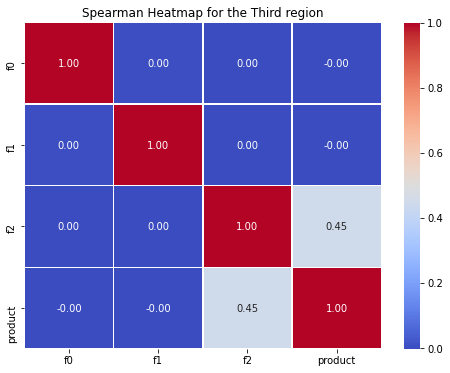

In [11]:
spearman_matrix = geo_data_2.drop('id', 1).corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman Heatmap for the Third region")
plt.show()

Линейная зависимосто в данных почти отсутствует. Модели сложно будет верно предсказывать значения в этом регионе. 

#### Вывод

Первый регион:
- В первом регионе первый признак показал мультимодальное расределение с тремя ярковыраженными пиками. Наблюдается сегментирование. При этом среднее и медиана совпали.
- У второго признака сегментация не такая выраженная. При этом гистограмма зеркалит по линии среднего, что указывает на особенность содержания данных. Скорее всего это результаты каких-то измерений.
- Третий признак имеет низкую дисперсию и наличие выбросов по обоим хвостам гистограммы. 
- Целевой признак первого региона имеет нормальное распределение среднее значение составило 92 ед. 
- Корреляционный анализ показал, что f2 имеет среднюю положительную корреляцию с целевой переменной product. Также мы видим, что у признаков f0 и f1 наблюдается умеренная отрицательная корреляция. В любом случае, мы выяснили, что линейная зависимость в данных присутствует, поэтому Линейная регрессия нам подходит
___
Второй регион:
- Первый признак имеет бимодальное распределение и высокую дисперсию. Данные разделились на две группы.
- Второй признак имеет нормальное распределение и низкую дисперсию. По обе стороны графика обнаружены выбросы.
- Третий признак имеет преобладание высоких значений, об этом говорит нам смещение среднего вправо. При этом данные сгруппировались и некоторые группы имеют равновероятные значения. 
- Целевой признак также имеет сгруппированный характер данных. Возможно это связанно с районированием скважин в данном регионе. Замечены пики у мин и макс значений. Среднее значение составило 69
- Наблюдается сильная прямопропорциональная корреляция между признаком f2 и целевым product. Линейная зависимость присутствует.
___
Третий регион:
- Все три признака имеют низкую дисперсию и выбросы по обе стороны хвоста. 
- Целевой признак распределен нормально со средним 95 ед. 
- Корреляционный анализ показал отсутсвие линейной зависимости в данных. 

## Обучение и проверка модели

Нам нужно написать три модели Линейной регрессии для предсказания уровня запасов нефти в регионах. Т.к. подготовка данных у нас будет одинаковой, для начала мы напишем общий пайплайн по подготовке данных, подберем лучшее масштабирование и оценим их с помощью метрики RMSE. Далее для каждой модели проведем анализ остатков, чтобы оценить ее предсказательную способность. 

### Первая модель

In [12]:
x_0 = geo_data_0.drop(['id', 'product'], 1)
y_0 = geo_data_0['product']

RANDOM_STATE=12345

x_0_train, x_0_valid, y_0_train, y_0_valid = train_test_split(x_0, y_0, random_state=RANDOM_STATE, test_size=0.25)

In [13]:
num_columns = x_0.columns

data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
)

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
]) 

In [14]:
%%time

param_distributions = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']  
    }
] 

grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
grid_search.fit(x_0_train, y_0_train)

CPU times: user 1.13 s, sys: 1.15 s, total: 2.28 s
Wall time: 2.26 s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['f0', 'f1', 'f2'], dtype='object'))])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']}],
             scoring='neg_mean_squared_error')

In [15]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['f0', 'f1', 'f2'], dtype='object'))])),
                ('models', LinearRegression())])

In [16]:
pred_0 = grid_search.predict(x_0_valid)

print('Средний запас предсказанного сырья в первом регионе', round(pred_0.mean(), 2))
print('RMSE', mean_squared_error(pred_0, y_0_valid)**0.5)

Средний запас предсказанного сырья в первом регионе 92.59
RMSE 37.5794217150813


В ходе моделирования выяснилось, что для первого региона в качестве скейлера лучше всего себя показал MinMaxScaler. Средний запас предсказанного сырья в первом регионе составил 92.59, а среднеквадратичная ошибка составила 37.5

#### Анализ остатков

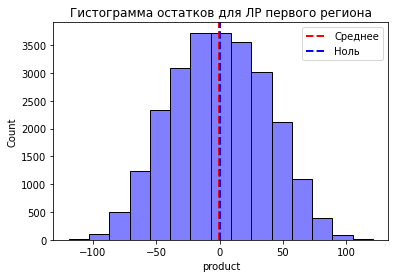

Среднее по остаткам -0.514


In [17]:
sns.histplot(y_0_valid - pred_0, kde=False, 
             bins=15, color = 'blue', alpha=0.5)
plt.title('Гистограмма остатков для ЛР первого региона')

plt.axvline((y_0_valid - pred_0).mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
plt.axvline(0, color='blue', linestyle='dashed', linewidth=2, label='Ноль')
plt.legend()
plt.show()
print(f'Среднее по остаткам {(y_0_valid - pred_0).mean():.3f}')

Гистограмма отсатков показывает случайность остатков модели. При этом среднее и ноль практически совпадает - это означает, что наша модель хорошо улавливает закономерности в данных. Выбросы отсутствуют

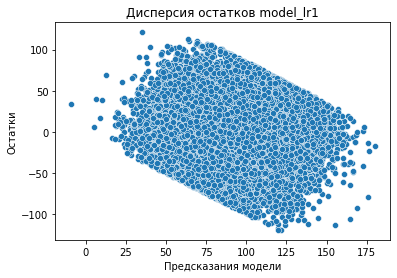

Дисперсия остатков 1412.0052504163323


In [18]:
sns.scatterplot(x=pred_0, y=y_0_valid - pred_0)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Дисперсия остатков model_lr1')
plt.show()
print(f'Дисперсия остатков {(y_0_valid - pred_0).var()}')

Дисперсия остатков равномерная по мере увеличения значения предсказаний модели.

### Вторая модель

In [19]:
x_1 = geo_data_1.drop(['id', 'product'], 1)
y_1 = geo_data_1['product']

x_1_train, x_1_valid, y_1_train, y_1_valid = train_test_split(x_1, y_1, random_state=RANDOM_STATE, test_size=0.25)

num_columns = x_1.columns

In [20]:
%%time
grid_search_1 = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
grid_search_1.fit(x_1_train, y_1_train)

CPU times: user 1.17 s, sys: 1.36 s, total: 2.53 s
Wall time: 2.51 s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['f0', 'f1', 'f2'], dtype='object'))])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']}],
             scoring='neg_mean_squared_error')

In [21]:
grid_search_1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['f0', 'f1', 'f2'], dtype='object'))])),
                ('models', LinearRegression())])

In [22]:
pred_1 = grid_search_1.predict(x_1_valid)

print('Средний запас предсказанного сырья в первом регионе', round(pred_1.mean(), 2))
print('RMSE', mean_squared_error(pred_1, y_1_valid)**0.5)

Средний запас предсказанного сырья в первом регионе 68.73
RMSE 0.893099286775617


Средняя ошибка прогноза второй модели составила 0.89 ед. При этом, средний запас предсказанного сырья во втором регионе составил 68.73. Меньше, чем в первом. Скейлер выбрали тот же. 

#### Анализ остатков

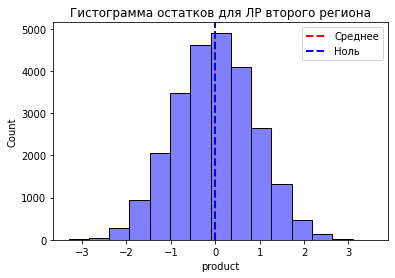

Среднее по остаткам -0.005


In [23]:
sns.histplot(y_1_valid - pred_1, kde=False, 
             bins=15, color = 'blue', alpha=0.5)
plt.title('Гистограмма остатков для ЛР второго региона')

plt.axvline((y_1_valid - pred_1).mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
plt.axvline(0, color='blue', linestyle='dashed', linewidth=2, label='Ноль')
plt.legend()
plt.show()
print(f'Среднее по остаткам {(y_1_valid - pred_1).mean():.3f}')

Гистограмма остатков показала, что среднее равно нулю, а распределение нормальное и без выбросов. Вторая модель еще лучше научилась находить закономерности в данных.

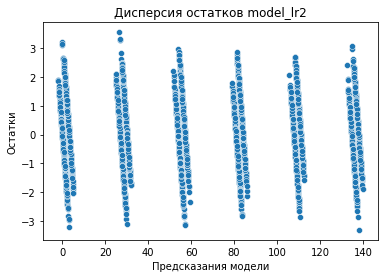

Дисперсия остатков 0.797628963671753


In [24]:
sns.scatterplot(x=pred_1, y=y_1_valid - pred_1)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Дисперсия остатков model_lr2')
plt.show()
print(f'Дисперсия остатков {(y_1_valid - pred_1).var()}')

Дисперсия остатков относительно равномерная по мере увеличения значений целевой переменной.

### Третья модель

In [25]:
x_2 = geo_data_2.drop(['id', 'product'], 1)
y_2 = geo_data_2['product']

x_2_train, x_2_valid, y_2_train, y_2_valid = train_test_split(x_2, y_2, random_state=RANDOM_STATE, test_size=0.25)

num_columns = x_2.columns

In [26]:
%%time
grid_search_2 = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
grid_search_2.fit(x_2_train, y_2_train)

CPU times: user 1.31 s, sys: 1.55 s, total: 2.86 s
Wall time: 2.87 s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['f0', 'f1', 'f2'], dtype='object'))])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']}],
             scoring='neg_mean_squared_error')

In [27]:
grid_search_2.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['f0', 'f1', 'f2'], dtype='object'))])),
                ('models', LinearRegression())])

In [28]:
pred_2 = grid_search_2.predict(x_2_valid)

print('Средний запас предсказанного сырья в первом регионе', round(pred_2.mean(), 2))
print('RMSE', mean_squared_error(pred_2, y_2_valid)**0.5)

Средний запас предсказанного сырья в первом регионе 94.97
RMSE 40.02970873393434


Третья модель выбрала тот же скейлер, что и предыдущие. При этом она показала самый высоукий средний запас предсказанного сырья со средней ошибкой в предсказаниях, равной 40.

#### Анализ остатков

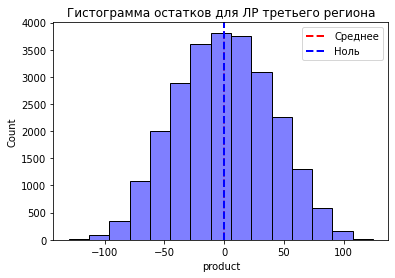

Среднее по остаткам -0.081


In [29]:
sns.histplot(y_2_valid - pred_2, kde=False, 
             bins=15, color = 'blue', alpha=0.5)
plt.title('Гистограмма остатков для ЛР третьего региона')

plt.axvline((y_2_valid - pred_2).mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
plt.axvline(0, color='blue', linestyle='dashed', linewidth=2, label='Ноль')
plt.legend()
plt.show()
print(f'Среднее по остаткам {(y_2_valid - pred_2).mean():.3f}')

Гистограмма остатков имеет нормальное распределение со средним 0. 

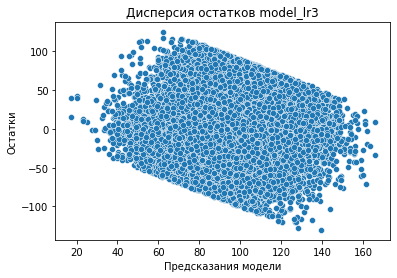

Дисперсия остатков 1602.4351479628458


In [30]:
sns.scatterplot(x=pred_2, y=y_2_valid - pred_2)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Дисперсия остатков model_lr3')
plt.show()
print(f'Дисперсия остатков {(y_2_valid - pred_2).var()}')

Дисперсия равномерная по всей ширине графика.

### Вывод по моделированию

В ходе моделирования мы написали три модели для расчета запасов сырья в трех регионах. Все три модели масштабировали признаки через MinMaxScaler. Теперь сравним среднее предсказанное количество запасов сырья, анализ остатков и RMSE каждой модели:
- В третьем регионе по предсказанию среднее предсказанное кол-во запасов больше всего - 94.97 единиц. 
- При этом среднеквадратичная ошибка ниже всего у второй модели - 0.89 ед.
- Анализ остатков показал, что вторая и третья модели имеют остатки, нормально распределенные вокруг нуля. При этом дисперсия остатков везде равномерная. 
- Среднее по всем трем регионам, исходя из Исследовательского Анализа Данных составило 92.5, 69 и 95 соответственно. Судя по моделированию и исследовательскому анализу данных, третий регион, в среднем, имеет наибольшее кол-во запасов сырья. Далее проверим прибыльность каждого региона и оформим финальный вывод.

## Подготовка к расчёту прибыли

Введем новые константы. Для начала нам нужно рассчитать достаточный объем сырья для безубыточной разработки новой скважины. 

In [31]:
ONE_UNIT_INCOME = 450 # с одной единицы сырья мы получим 450 тыс. руб. 
BUDGET = 10_000_000 # бюджет на разработку 10 000 000 тыс. руб
COUNT=200 # лушчие скважины 
EXPLOR=500 # разведка

state = np.random.RandomState(12345)
NUM_SAMPLES=1000
alpha = 0.025

volume_of_materials = (BUDGET / COUNT) / ONE_UNIT_INCOME
print('Объем сырья для безубыточной разработки', round(volume_of_materials, 2))

Объем сырья для безубыточной разработки 111.11


Теперь сравним объем сырья для безубыточной разработки со средним предсказанным объемом сырья на валидации у лучших 200 точек

In [32]:
print('Средний предсказанный объем сырья у лучших 200 точек первого региона', 
      pd.Series(pred_0).sort_values(ascending=False)[:200].mean())

Средний предсказанный объем сырья у лучших 200 точек первого региона 155.511654194057


In [33]:
print('Средний предсказанный объем сырья у лучших 200 точек второго региона', 
      pd.Series(pred_1).sort_values(ascending=False)[:200].mean())

Средний предсказанный объем сырья у лучших 200 точек второго региона 138.73013391081716


In [34]:
print('Средний предсказанный объем сырья у лучших 200 точек третьего региона', 
      pd.Series(pred_2).sort_values(ascending=False)[:200].mean())

Средний предсказанный объем сырья у лучших 200 точек третьего региона 148.01949329159171


Теперь соберем предсказания и таргет в один датафрейм для удобных вычеслений

In [35]:
materials_0 = pd.DataFrame(pd.Series(pred_0))
materials_0['real'] = y_0_valid.reset_index(drop=True)
materials_0.columns = ['pred', 'real']
materials_0.head()

,pred,real
0,95.894952,10.038645
1,77.572583,114.551489
2,77.892640,132.603635
3,90.175134,169.072125
4,70.510088,122.325180


In [36]:
materials_1 = pd.DataFrame(pd.Series(pred_1))
materials_1['real'] = y_1_valid.reset_index(drop=True)
materials_1.columns = ['pred', 'real']
materials_1.head()

,pred,real
0,82.663314,80.859783
1,54.431786,53.906522
2,29.748760,30.132364
3,53.552133,53.906522
4,1.243856,0.000000


In [37]:
materials_2 = pd.DataFrame(pd.Series(pred_2))
materials_2['real'] = y_2_valid.reset_index(drop=True)
materials_2.columns = ['pred', 'real']
materials_2.head()

,pred,real
0,93.599633,61.212375
1,75.105159,41.850118
2,90.066809,57.776581
3,105.162375,100.053761
4,115.303310,109.897122


### Вывод по подготовке к расчету прибыли

Исходя из значений среднего предсказанного объема сырья для 200 лучших точек каждого региона можно сделать вывод ,что каждый из трех регионов пригоден для безубыточной разработки скважины. Теперь остается только посчитать прибыль

## Расчёт прибыли и рисков 

In [38]:
def income(one_unit_income, data, budget, count):
    best_points = data.sort_values(['pred'], ascending=False)['real'][:count] # сортируем датасет по столбцу с предсказаниями 
                                                              # и выбираем первые 200 точек по столбцу с реальными значениями
    total_volume = sum(best_points) # суммируем значения
    return (total_volume * one_unit_income) - budget  # считаем прибыль - расходы на разработку скважины

In [39]:
print('Прибыль первого региона равна', income(data=materials_0, 
                                              one_unit_income=ONE_UNIT_INCOME, 
                                              budget=BUDGET,
                                              count=COUNT
                                              ))
print('Прибыль второго региона равна', income(data=materials_1, 
                                              one_unit_income=ONE_UNIT_INCOME, 
                                              budget=BUDGET,
                                              count=COUNT
                                              ))
print('Прибыль третьего региона равна', income(data=materials_2, 
                                               one_unit_income=ONE_UNIT_INCOME, 
                                               budget=BUDGET,
                                               count=COUNT
                                               ))

Прибыль первого региона равна 3320826.0431398544
Прибыль второго региона равна 2415086.6966815516
Прибыль третьего региона равна 2710349.9635998365


Теперь посчитаем распределение прибыли с помощью техники Bootstrap для первого региона

In [40]:
def bootstrap_income(one_unit_income, data, explor, num_samples, budget, count):
    incomes = []
    for _ in range(num_samples):
        best_points = data.sample(explor, replace=True, random_state=state)
        income_value = income(one_unit_income, best_points, budget, count)
        incomes.append(income_value)
    return incomes

In [41]:
bootstrap_first = pd.Series(bootstrap_income(ONE_UNIT_INCOME, materials_0, EXPLOR, NUM_SAMPLES, BUDGET, COUNT))
bootstrap_second = pd.Series(bootstrap_income(ONE_UNIT_INCOME, materials_1, EXPLOR, NUM_SAMPLES, BUDGET, COUNT))
bootstrap_third = pd.Series(bootstrap_income(ONE_UNIT_INCOME, materials_2, EXPLOR, NUM_SAMPLES, BUDGET, COUNT))

После того как мы с помощью бутстрэпа посчитали распределение прибыли - время приступить к расчету доверительного интервала!

In [42]:
print('Точка минимум доверительного интервала первого региона', bootstrap_first.quantile(q=alpha))
print('Точка максимум доверительного интервала первого региона', bootstrap_first.quantile(q=1-alpha))

Точка минимум доверительного интервала первого региона -111215.5458904942
Точка максимум доверительного интервала первого региона 909766.94155342


In [43]:
print('Точка минимум доверительного интервала второго региона', bootstrap_second.quantile(q=alpha))
print('Точка максимум доверительного интервала второго региона', bootstrap_second.quantile(q=1-alpha))

Точка минимум доверительного интервала второго региона 78050.81075175606
Точка максимум доверительного интервала второго региона 862952.0602637421


In [44]:
print('Точка минимум доверительного интервала третьего региона', bootstrap_third.quantile(q=alpha))
print('Точка максимум доверительного интервала третьего региона', bootstrap_third.quantile(q=1-alpha))

Точка минимум доверительного интервала третьего региона -112227.62537857192
Точка максимум доверительного интервала третьего региона 934562.9145511603


После расчета доверительного интервала нам необходимо посчитать риски убыточности для каждого региона по 200 лeчшим точкам. Для этого мы сравним объем сырья каждой точки с объемом для безубыточной разработки и посчитаем число точек, объем сырья которых ниже указанного

In [45]:
count = 0
for i in range(1000):
    if (bootstrap_first[i] <= 0).any():
        count += 1

prob = (count / len(bootstrap_first)) * 100

if alpha*100 >  prob:
    print('Вероятность убытков меньше порогового значения: не исключаем первый регион')
else:
    print('Вероятность убытков больше порогового значения: исключаем первый регион')
    
print('Вероятность', prob)

Вероятность убытков больше порогового значения: исключаем первый регион
Вероятность 6.9


In [46]:
count = 0
for i in range(1000):
    if (bootstrap_second[i] <= 0).any():
        count += 1

prob = (count / len(bootstrap_second)) * 100

if alpha*100 >  prob:
    print('Вероятность убытков меньше порогового значения: не исключаем второй регион')
else:
    print('Вероятность убытков больше порогового значения: исключаем второй регион')
    
print('Вероятность', prob)

Вероятность убытков меньше порогового значения: не исключаем второй регион
Вероятность 0.7000000000000001


In [47]:
count = 0
for i in range(1000):
    if (bootstrap_third[i] <= 0).any():
        count += 1

prob = (count / len(bootstrap_third)) * 100

if alpha*100 >  prob:
    print('Вероятность убытков меньше порогового значения: не исключаем третий регион')
else:
    print('Вероятность убытков больше порогового значения: исключаем третий регион')
    
print('Вероятность', prob)

Вероятность убытков больше порогового значения: исключаем третий регион
Вероятность 6.5


### Вывод.

Исходя из расчетов среднего объема сырья, прибыли, доверительного интервала и анализа рисков можно сделать следующий вывод. Так как, анализ среднего объема сырья показал, что все три региона пригодны для бурения скважины, но анализ рисков показал, что первый и третий регион имеют риски убыточности, равные 6.9% и 6.5% соответственно, что выше порогового значения 2.5%. Таким образом, наиболее выгодным регионом для бурения скважины является Второй регион. Прибыль с него составит 2415087 тыс руб., а доверительный интервал [78051, 862952]. Риск убыточности составил 0.7%

## Вывод

В ходе выполнения проекта была поставлена задача разработать модель, которая будет предсказывать объем сырья для каждого региона, который в последствие будет необходим нам для расчета прибыльности и принятия решения по целесообразности бурения там скважины. 
Нам были предоставлены 3 датасета с данными по точкам каждого региона и вот какие закономерности мы там нашли:
___
Первый регион:
- В первом регионе первый признак показал мультимодальное расределение с тремя ярковыраженными пиками. Наблюдается сегментирование. При этом среднее и медиана совпали.
- У второго признака сегментация не такая выраженная. При этом гистограмма зеркалит по линии среднего, что указывает на особенность содержания данных. Скорее всего это результаты каких-то измерений.
- Третий признак имеет низкую дисперсию и наличие выбросов по обоим хвостам гистограммы. 
- Целевой признак первого региона имеет нормальное распределение среднее значение составило 92 ед. 
- Корреляционный анализ показал, что f2 имеет среднюю положительную корреляцию с целевой переменной product. Также мы видим, что у признаков f0 и f1 наблюдается умеренная отрицательная корреляция. В любом случае, мы выяснили, что линейная зависимость в данных присутствует, поэтому Линейная регрессия нам подходит
___
Второй регион:
- Первый признак имеет бимодальное распределение и высокую дисперсию. Данные разделились на две группы.
- Второй признак имеет нормальное распределение и низкую дисперсию. По обе стороны графика обнаружены выбросы.
- Третий признак имеет преобладание высоких значений, об этом говорит нам смещение среднего вправо. При этом данные сгруппировались и некоторые группы имеют равновероятные значения. 
- Целевой признак также имеет сгруппированный характер данных. Возможно это связанно с районированием скважин в данном регионе. Замечены пики у мин и макс значений. Среднее значение составило 69
- Наблюдается сильная прямопропорциональная корреляция между признаком f2 и целевым product. Линейная зависимость присутствует.
___
Третий регион:
- Все три признака имеют низкую дисперсию и выбросы по обе стороны хвоста. 
- Целевой признак распределен нормально со средним 95 ед. 
- Корреляционный анализ показал отсутсвие линейной зависимости в данных. 

___
После исследования мы написали пайплайна для модели линейной регрессии для каждого региона и провели анализ остатков. Вот какие выводы нам удалось сделать: Все три модели масштабировали признаки через MinMaxScaler. Теперь сравним среднее предсказанное количество запасов сырья, анализ остатков и RMSE каждой модели:
- В третьем регионе по предсказанию среднее предсказанное кол-во запасов больше всего - 94.97 единиц. 
- При этом среднеквадратичная ошибка ниже всего у второй модели - 0.89 ед.
- Анализ остатков показал, что вторая и третья модели имеют остатки, нормально распределенные вокруг нуля. При этом дисперсия остатков везде равномерная. 
- Среднее по всем трем регионам, исходя из Исследовательского Анализа Данных составило 92.5, 69 и 95 соответственно. Судя по моделированию и исследовательскому анализу данных, третий регион, в среднем, имеет наибольшее кол-во запасов сырья.
___

При подсчете прибыли и анализе рисков мы сделали следующий вывод: Исходя из расчетов среднего объема сырья, прибыли, доверительного интервала и анализа рисков можно сделать следующий вывод. Так как, анализ среднего объема сырья показал, что все три региона пригодны для бурения скважины, но анализ рисков показал, что первый и третий регион имеют риски убыточности, равные 6.9% и 6.5% соответственно, что выше порогового значения 2.5%. Таким образом, наиболее выгодным регионом для бурения скважины является Второй регион. Прибыль с него составит 2415087 тыс руб., а доверительный интервал [78051, 862952]. Риск убыточности составил 0.7%